### Importing key libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import cv2
import os
import warnings
warnings.filterwarnings("ignore")

### Dataset

In [2]:
base_path = "datasets/IraqiAD"
categories = ["AD", "CN"]   # Alzheimer's disease (AD) & Cognitively Normal (CN)

image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

pd.concat([df.head(), df.tail()])

,image_path,label
0,datasets/IraqiAD/AD/AD_0563.jpg,AD
1,datasets/IraqiAD/AD/AD_0560.jpg,AD
2,datasets/IraqiAD/AD/AD_2106.jpg,AD
3,datasets/IraqiAD/AD/AD_3346.jpg,AD
4,datasets/IraqiAD/AD/AD_3456.jpg,AD
6800,datasets/IraqiAD/CN/CN_0588.jpg,CN
6801,datasets/IraqiAD/CN/CN_0402.jpg,CN
6802,datasets/IraqiAD/CN/CN_0430.jpg,CN
6803,datasets/IraqiAD/CN/CN_2868.jpg,CN
6804,datasets/IraqiAD/CN/CN_1274.jpg,CN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6805 entries, 0 to 6804
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  6805 non-null   object
 1   label       6805 non-null   object
dtypes: object(2)
memory usage: 106.5+ KB


In [4]:
df['label'].value_counts()

,count
label,
AD,3639
CN,3166


#### Bar chart

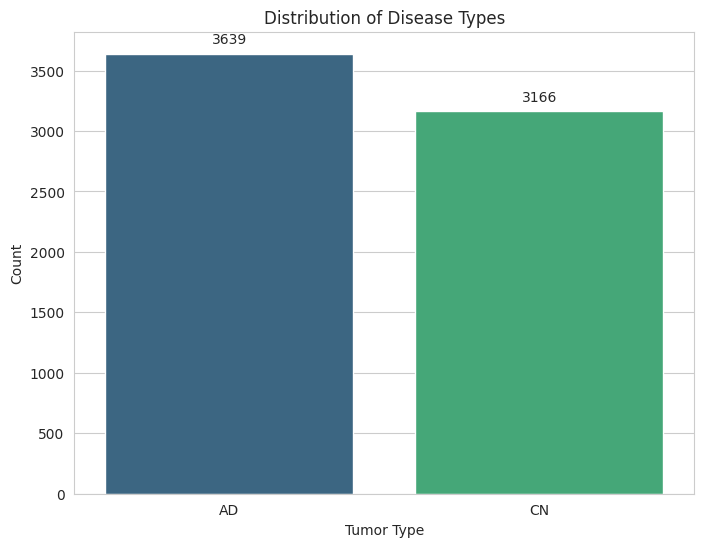

In [5]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=df, x="label", hue="label", palette="viridis")
ax.set_title("Distribution of Disease Types")
ax.set_xlabel("Tumor Type")
ax.set_ylabel("Count")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', textcoords='offset points', xytext=(0,5))
plt.show()

#### Pie chart

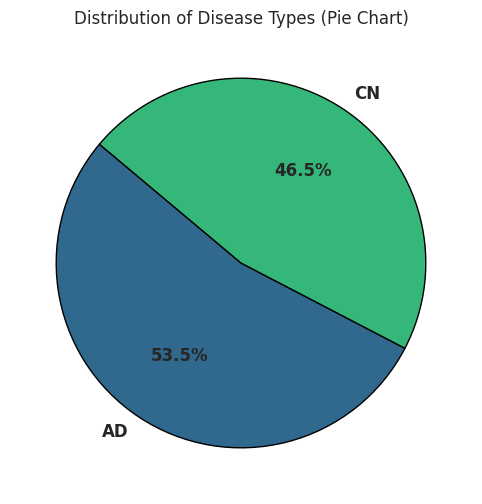

In [6]:
label_counts = df["label"].value_counts()
fig, ax = plt.subplots(figsize=(8,6))
colors = sns.color_palette("viridis", len(label_counts))
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
       startangle=140, colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax.set_title("Distribution of Disease Types (Pie Chart)")
plt.show()

### Data visualization

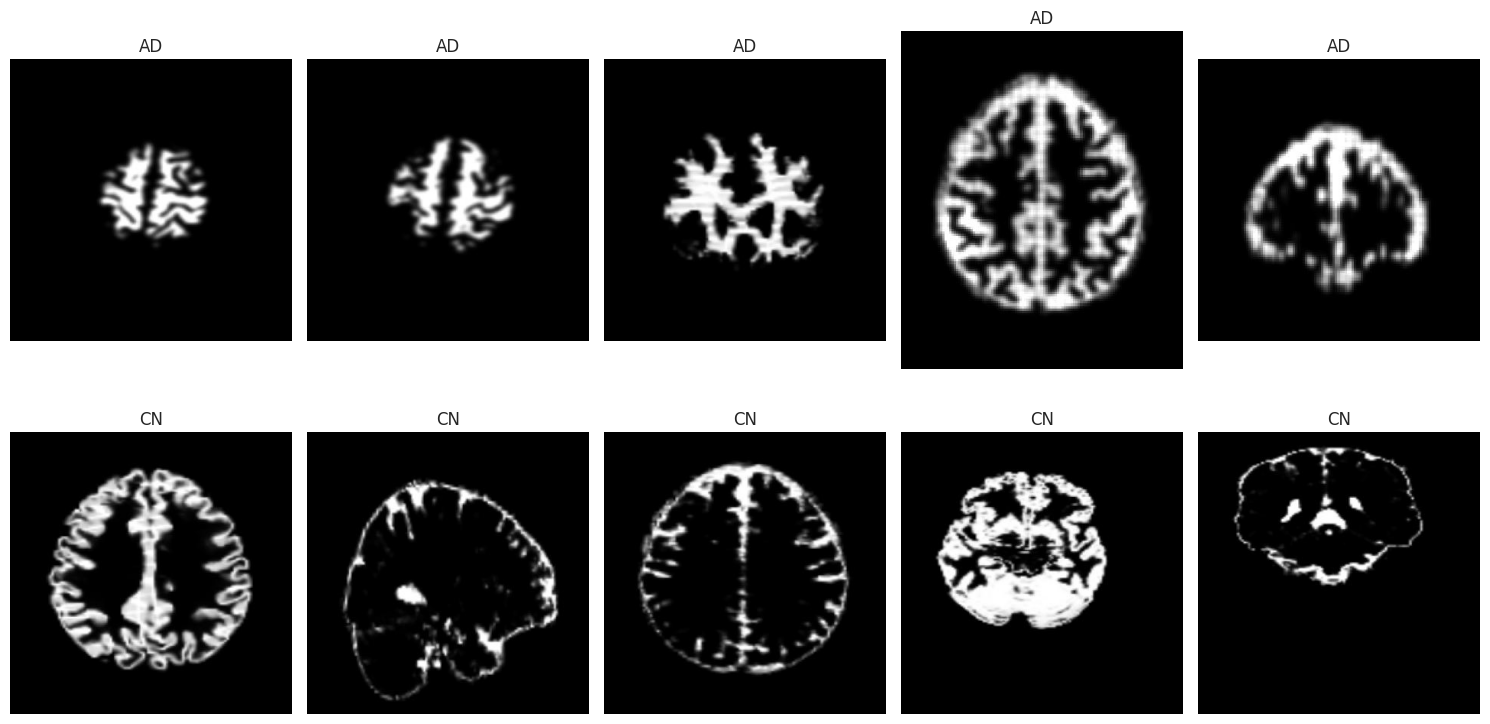

In [7]:
num_images = 5
plt.figure(figsize=(15,8))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]
    for j, img_path in enumerate(category_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)
plt.tight_layout()
plt.show()

### Label encoding

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])
df = df[['image_path', 'category_encoded']]
min_samples = df['category_encoded'].value_counts().min()
balanced_df = df.groupby('category_encoded').sample(n=min_samples, random_state=42)
balanced_df = balanced_df.reset_index(drop=True)
balanced_df = balanced_df[['image_path', 'category_encoded']]
print(balanced_df)

                           image_path  category_encoded
0     datasets/IraqiAD/AD/AD_1860.jpg                 0
1     datasets/IraqiAD/AD/AD_1992.jpg                 0
2     datasets/IraqiAD/AD/AD_3330.jpg                 0
3     datasets/IraqiAD/AD/AD_3490.jpg                 0
4     datasets/IraqiAD/AD/AD_1057.jpg                 0
...                               ...               ...
6327  datasets/IraqiAD/CN/CN_0843.jpg                 1
6328  datasets/IraqiAD/CN/CN_0711.jpg                 1
6329  datasets/IraqiAD/CN/CN_1836.jpg                 1
6330  datasets/IraqiAD/CN/CN_2392.jpg                 1
6331  datasets/IraqiAD/CN/CN_1570.jpg                 1

[6332 rows x 2 columns]


### Data split

In [9]:
df_resampled = balanced_df
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

train_df_new, temp_df_new = sklearn.model_selection.train_test_split(df_resampled, train_size=0.8,
                                                                     shuffle=True, random_state=42,
                                                                     stratify=df_resampled['category_encoded'])

valid_df_new, test_df_new = sklearn.model_selection.train_test_split(temp_df_new, test_size=0.5, shuffle=True,
                                                                     random_state=42, stratify=temp_df_new['category_encoded'])

### Generating dataset

In [10]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)

tr_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
ts_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224,224),
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224,224),
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224,224),
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE
)

Found 5065 validated image filenames belonging to 2 classes.
Found 633 validated image filenames belonging to 2 classes.
Found 634 validated image filenames belonging to 2 classes.


### Model and loss func. classes

In [11]:
class ContinuousLayer(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, num_basis=10,
                 output_channels=16, **kwargs):
        super(ContinuousLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.num_basis = num_basis
        self.output_channels = output_channels
        self.centers = self.add_weight(
            name='centers',
            shape=(num_basis, 2),
            initializer='random_normal',
            trainable=True
        )
        self.widths = self.add_weight(
            name='widths',
            shape=(num_basis,),
            initializer='ones',
            trainable=True,
            constraint=tf.keras.constraints.NonNeg()
        )
        self.kernel_weights = self.add_weight(
            name='kernel_weights',
            shape=(kernel_size, kernel_size, CHANNELS, output_channels),
            initializer='glorot_normal',
            trainable=True
        )

    def call(self, inputs):
        height, width = (224,224)
        x = tf.range(0, height, 1.0)
        y = tf.range(0, width, 1.0)
        x_grid, y_grid = tf.meshgrid(x,y)
        grid = tf.stack([x_grid, y_grid], axis=-1)

        basis=[]
        for i in range(self.num_basis):
            center = self.centers[i]
            width = self.widths[i]
            dist = tf.reduce_sum(((grid - center) / width) ** 2, axis=-1)
            basis_i = tf.exp(-dist)
            basis.append(basis_i)
        basis = tf.stack(basis, axis=-1)

        basis_weights = tf.reduce_mean(basis, axis=[0,1])
        basis_weights = tf.nn.softmax(basis_weights)
        basis_weights = basis_weights[:, tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis]

        modulated_kernel = self.kernel_weights * tf.reduce_sum(basis_weights, axis=0)

        output = tf.nn.conv2d(inputs, modulated_kernel, strides=[1,1,1,1],
                              padding='SAME')

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.output_channels)

    def smoothness_penalty(self):
        grad_x = tf.reduce_mean(tf.square(self.kernel_weights[1:, :, :, :] -
                                          self.kernel_weights[:-1, :, :, :]))
        grad_y = tf.reduce_mean(tf.squre(self.kernel_weights[:, 1:, :, :] -
                                         self.kernel_weights[:, :-1, :, :]))
        return grad_x + grad_y


class VariationalLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda1=0.01, lambda2=1.0):
        super(VariationalLoss, self).__init__()
        self.model = model
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.bce = tf.keras.losses.BinaryCrossentropy()

    def call(self, y_true, y_pred):
        smoothness_penalty = 0
        for layer in self.model.layers:
            if isinstance(layer, ContinuousLayer):
                smoothness_penalty += layer.smoothness_penalty()
            prediction_loss = self.bce(y_true, y_pred)
            return self.lambda2 * prediction_loss + self.lambda1 * smoothness_penalty


def build_continuous_model():
    inputs = tf.keras.layers.Input(shape=IMG_SHAPE)
    x = ContinuousLayer(kernel_size=5, num_basis=10, output_channels=16)(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs, outputs)
    return model

model = build_continuous_model()

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ continuous_layer                │ (None, 224, 224, 16)   │         1,230 │
│ (ContinuousLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,691,599 (98.01 MB)

 Trainable params: 25,691,599 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

### Defining callbacks

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Custom training curve callback
from IPython.display import clear_output

train_losses=[]; val_losses=[]; precision_scores=[]; recall_scores=[]

class TrainingCurveCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['loss'])
        val_losses.append(logs['val_loss'])
        precision_scores.append(logs['precision'])
        recall_scores.append(logs['recall'])

        clear_output(wait=True) # clear output before plotting

        fig, ax1 = plt.subplots(figsize=(10, 5)) # create figure; will contain loss/accuracy curves
        fig.suptitle('Training Curves')

        # loss curve (ax1 - left y axis)
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_xlim(left=0)
        ax1.set_ylabel('Loss function')

        # determine left y axis range from min/max loss values
        y_ax1_min = min(min(train_losses), min(val_losses)) # find lowest loss value across both curves
        y_ax1_min = max(0, y_ax1_min - 0.1) # add some padding to the bottom of the plot. lower bound can't be less than 0
        y_ax1_max = max(max(train_losses), max(val_losses)) + 0.1 # find highest loss value across both curves, add some padding to the top of the plot
        ax1.set_ylim(y_ax1_min, y_ax1_max) # set y axis limits

        # Best epoch (smallest loss)
        best_epoch = int(np.argmin(val_losses))
        best_loss = val_losses[best_epoch]

        # add veritcal line for best epoch
        ax1.vlines(best_epoch, ymin=0, ymax=y_ax1_max, linestyles='dashed', colors='black',
                   label=f'best epoch={best_epoch}\nval loss={best_loss:.3f}')
        ax1.legend(loc='upper left')

        # create right y axis for precision/recall curves
        ax2 = ax1.twinx()

        # Plot precision/recall (right y-axis)
        ax2.plot(precision_scores, label=f'Precision\n{precision_scores[best_epoch]:.3f} @ {best_epoch}', color='red')
        ax2.plot(recall_scores, label=f'Recall\n{recall_scores[best_epoch]:.3f} @ {best_epoch}', color='green')
        ax2.set_ylabel('Precision / Recall')
        ax2.set_ylim(0, 1.1) # add some padding
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

### Training the model

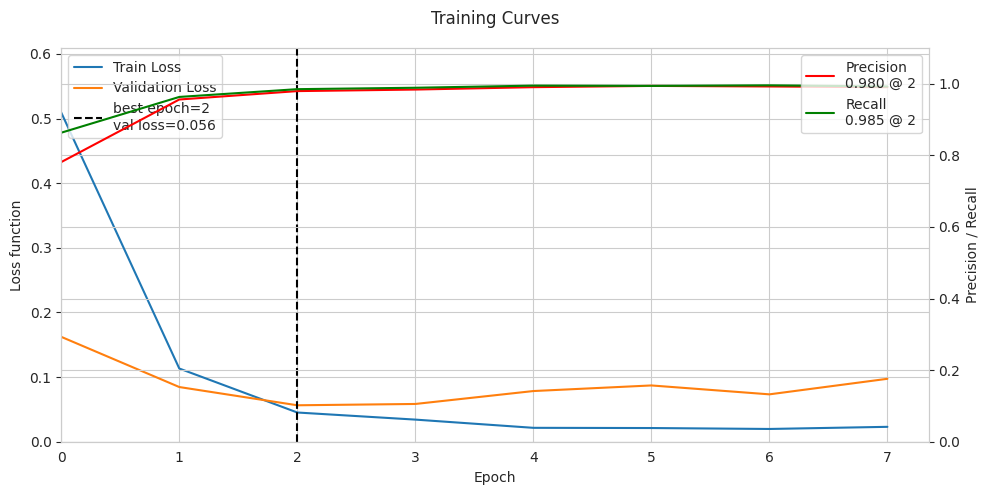

317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9940 - loss: 0.0195 - precision: 0.9935 - recall: 0.9946 - val_accuracy: 0.9700 - val_loss: 0.0974 - val_precision: 0.9569 - val_recall: 0.9842 - learning_rate: 0.0010


In [14]:
model.compile(optimizer='adam', loss=VariationalLoss(model=model, lambda1=0.01,
                                                     lambda2=1.0), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

history = model.fit(train_gen_new, validation_data=valid_gen_new, epochs=100, callbacks=[early_stopping, reduce_lr, TrainingCurveCallback()], verbose=1)

### Model evaluation

In [15]:
test_loss, test_accuracy, *rest = model.evaluate(test_gen_new)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9556 - loss: 0.1003 - precision: 0.9385 - recall: 0.9761
Test loss: 0.0861, Test accuracy: 0.9653


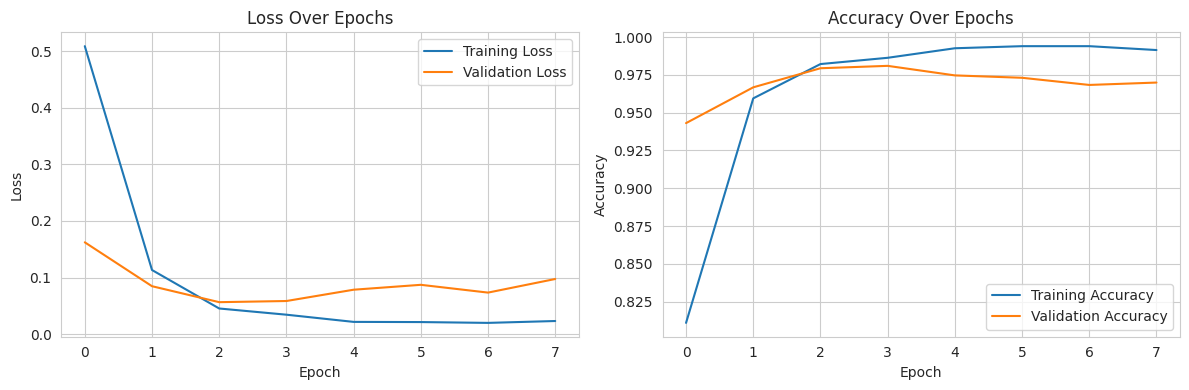

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


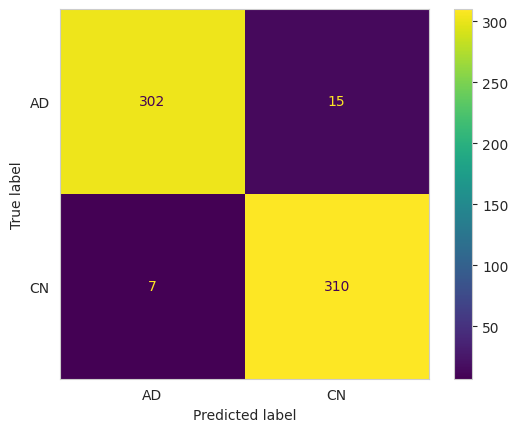

In [17]:
y_pred = model.predict(test_gen_new)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_gen_new.classes
cm = sklearn.metrics.confusion_matrix(y_true, y_pred_binary)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot()
plt.grid(False)
plt.show()

In [18]:
print("Classification report:")
print(sklearn.metrics.classification_report(y_true, y_pred_binary, target_names=categories))

Classification report:
              precision    recall  f1-score   support

          AD       0.98      0.95      0.96       317
          CN       0.95      0.98      0.97       317

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634

